# Finding chaos in time series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import statsmodels.tsa.stattools as stat
from tqdm import tqdm, trange, tqdm_notebook
import nolds  # calculation of maximum Lyapunov LE
%matplotlib inline

In [2]:
#Get data from Google trends
SRC_CSV = 'multiTimeline.csv'

In [3]:
df = pd.read_csv(SRC_CSV, index_col='Mes', parse_dates=['Mes'])
df = df.reset_index()

In [4]:
df.head()

,Mes,Comprar_online,Centro_comercial
0,2004-01-01,3,45
1,2004-02-01,2,35
2,2004-03-01,3,34
3,2004-04-01,3,39
4,2004-05-01,3,38


In [5]:
df.tail()

,Mes,Comprar_online,Centro_comercial
194,2020-03-01,29,26
195,2020-04-01,47,13
196,2020-05-01,30,32
197,2020-06-01,18,45
198,2020-07-01,16,51


In [6]:
df.describe()

,Comprar_online,Centro_comercial
count,199.000000,199.000000
mean,12.140704,51.859296
std,7.496821,12.558160
min,1.000000,13.000000
25%,4.000000,44.000000
50%,12.000000,50.000000
75%,18.000000,57.000000
max,47.000000,100.000000


In [72]:
# Mes: Month, 
#Comprar_online: To buy online
#Centro_comercial: Shopping Mall

### Visual estimation of trends series

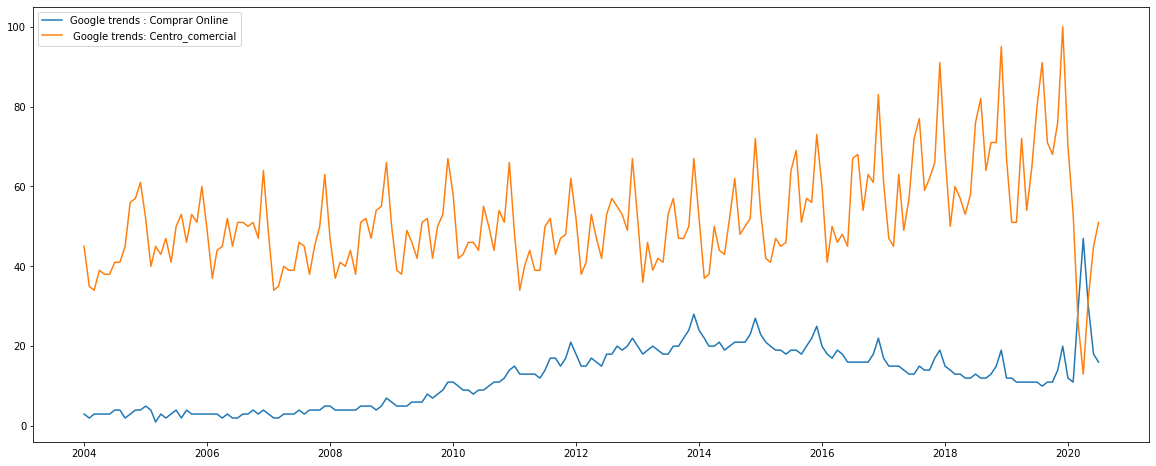

In [71]:
plt.figure(figsize=(20, 8))
plt.plot(df.Mes, df.Comprar_online, label='Google trends : Comprar Online')
plt.plot(df.Mes, df.Centro_comercial, label=' Google trends: Centro_comercial')
plt.legend()
plt.show()

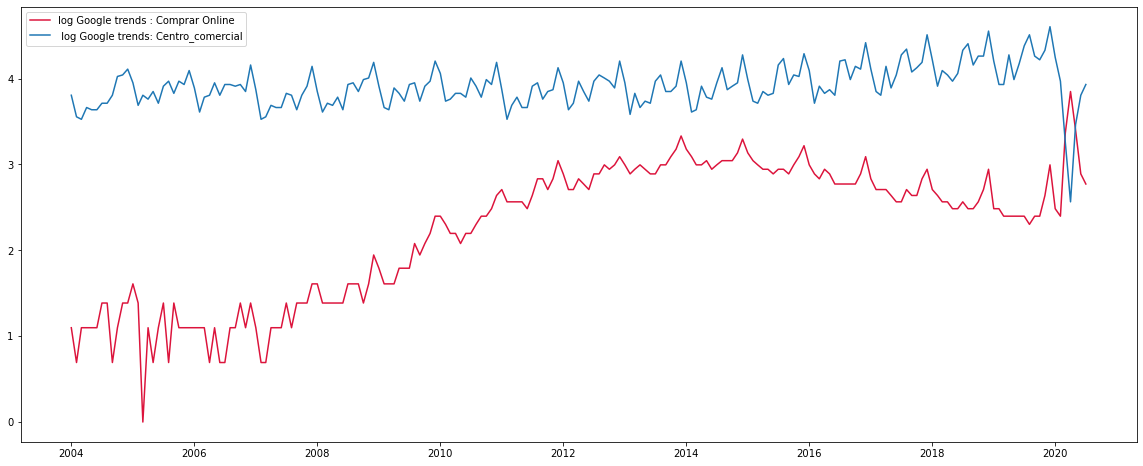

In [70]:
#log scale
plt.figure(figsize=(20, 8))
plt.plot(df.Mes, np.log(df.Comprar_online), color='crimson', label='log Google trends : Comprar Online')
plt.plot(df.Mes, np.log(df.Centro_comercial), label=' log Google trends: Centro_comercial')
plt.legend()
plt.show()

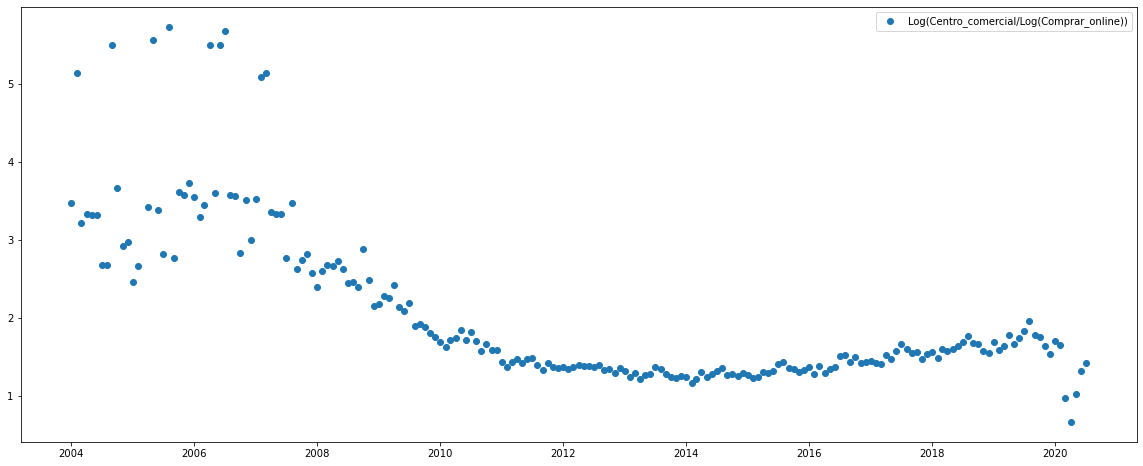

In [69]:
plt.figure(figsize=(20, 8))
plt.scatter(df.Mes, 
    np.log(df['Centro_comercial'])/np.log(df['Comprar_online']),
           label='Log(Centro_comercial/Log(Comprar_online))')
plt.legend()
plt.show()

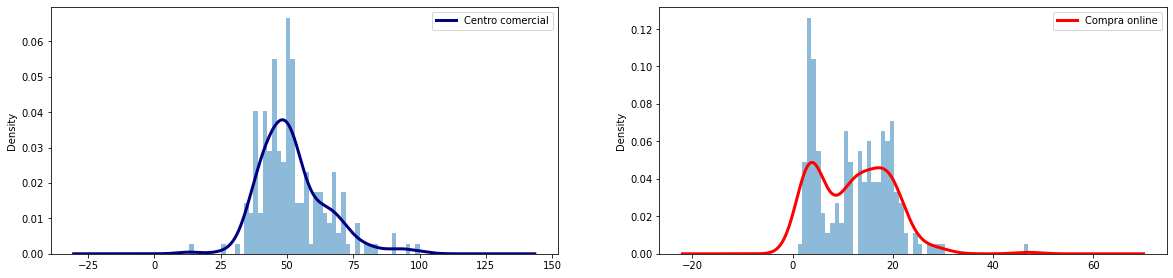

In [73]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(221)
df['Centro_comercial'].hist(ax=ax1, bins=50, density=True, alpha=0.5)
df['Centro_comercial'].plot.kde(ax=ax1, lw=3, c='navy', label='Centro comercial')
plt.legend()
ax2 = plt.subplot(222)
df['Comprar_online'].hist(ax=ax2, bins=50, density=True, alpha=0.5)
df['Comprar_online'].plot.kde(ax=ax2, c='red', lw=3, label='Compra online')
plt.legend()
plt.show()

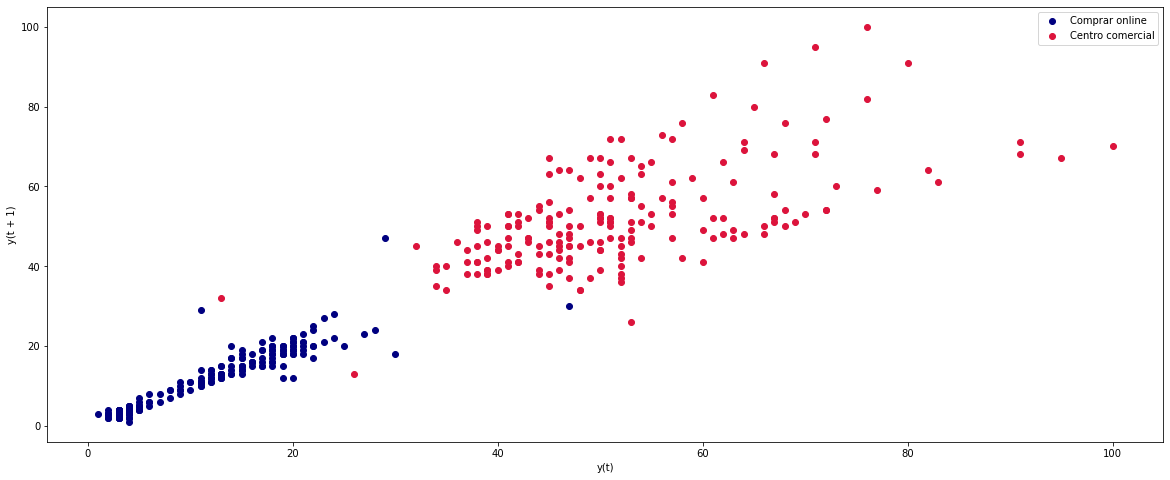

In [74]:
plt.figure(figsize=(20, 8))
pd.plotting.lag_plot(df['Comprar_online'], c='navy', label='Comprar online')
pd.plotting.lag_plot(df['Centro_comercial'],  c='crimson', label='Centro comercial')
plt.legend()

There is no autocorrelation for different lags.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

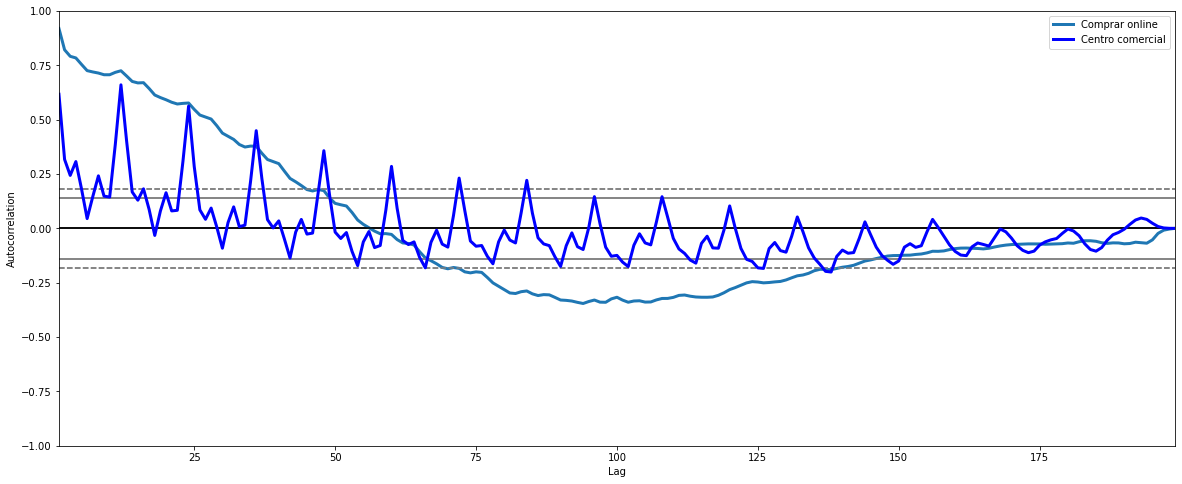

In [75]:
plt.figure(figsize=(20, 8))
pd.plotting.autocorrelation_plot(df['Comprar_online'], label='Comprar online', lw=3)
pd.plotting.autocorrelation_plot(df['Centro_comercial'], c='blue', label='Centro comercial', lw=3)

## Stationary time series 

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
- [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/), 

### BDS test 

BDS tests the null hypothesis of independent and identical distribution (i.i.d)
or the purpose of detecting non-random chaotic dynamics.

In [18]:
# BDS statistics 'Online'
bds, pval = stat.bds(df['Comprar_online'])
bds, pval

(array(45.18512944), array(0.))

In [19]:
# BDS statistics 'Centro comercial'
bds, pval = stat.bds(df['Centro_comercial'])
bds, pval

(array(8.37383465), array(5.57730001e-17))

If $BDS$ is high and $pval < 0.5$,  means that null hypothesis of i.i.d. rejected and the time series has non linear dynamic.

### Augumented Dickey-Fuller (ADF) test

$ADF$ tests the null hypothesis that time series has unit roots. If the hypothesis rejected, the time-series is stationary.

In [20]:
def adf(series):
    res = stat.adfuller(series)
    print("ADF statistics: {:.3f}".format(res[0]))
    print("p-value: {:.3f}".format(res[1]))
    crit_vals = res[4]
    cv = ['{}:{:.3f}'.format(k, v) for k,v in crit_vals.items()]
    print("critical values: ", cv)

In [22]:
adf(df['Comprar_online'])

ADF statistics: -0.841
p-value: 0.807
critical values:  ['1%:-3.466', '5%:-2.877', '10%:-2.575']


In [21]:
adf(df['Centro_comercial'])

ADF statistics: -2.084
p-value: 0.251
critical values:  ['1%:-3.467', '5%:-2.877', '10%:-2.575']


If 'ADF statistics' is lower than 'critical values', the null hypothesis is rejected and time series is stationary.


# Maximal Lyapunov Exponent (Roessler algorithm)

### Target: 'Higher MLE, less predictible is a time series'

An essential aspect of deterministic chaos is the fact that small differences in the initial values of a system's development over time can grow into very large differences. The reason for this is the exponential growth of these differences, which in principle is once more a feedback effect. Differences grow in respect to the size they have reached in the previous moment of time. The larger they are, the faster they grow.

This increase in differences measures the so-called Lyapunov exponent, named after the Russian mathematician Aleksandr Mikhailovich Lyapunov. This exponent indicates the speed with which two initially close dynamics diverge - if the L. exponent is positive - or converge - if the L. exponent is negative - in phase space. If the difference of the initial values is u0
, the difference at time t can be estimated as $|u_t|=e^{λt}∗|u_0|$, with $λ$ denoting the Lyapunov exponent, which can be calculated as $λ=lim 1/t∗ln|u_1/u_0|$.

The Lyapunov exponent hence indicates how rapidly a complex system of several interdependent dynamics tends to run up to deterministic chaos. The inverse value of the exponent indicates the so-called Lyapunov time, the time an initial difference needs to reach e
, thus allowing certain conclusions about the predictability of a system. Knowing Lyapunov time enables to estimate for what time period a system can be expected to be predictable.

In more-dimensional developments, there may be a whole spectrum of Lyapunov exponents. Usually only the largest of them is called Lyapunov exponent, or more accurately the Maximal Lyapunov Exponent (MLE). For a time discrete system $x_{t+1}=f(x_t)$ it is defined as:

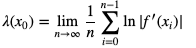

/Applications/anaconda3/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 49
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Applications/anaconda3/lib/python3.7/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 7
  warnings.warn(msg.format(lag), RuntimeWarning)


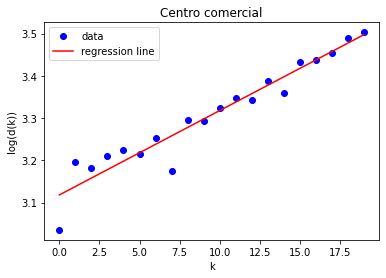

MLE (Rosenstein Algorithm)= 0.019952438289957845


In [23]:
# Estimates the largest Lyapunov exponent 
# (a positive exponent is a strong indicator for chaos)
# Centro comercial
plt.title('Centro comercial')
le = nolds.lyap_r(df['Centro_comercial'], debug_plot=True)
plt.show()
print ('MLE (Rosenstein Algorithm)=' , le)

The positive value of the largest LE shows that time-series can be described as a system sensitive to initial conditions.

/Applications/anaconda3/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 49
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Applications/anaconda3/lib/python3.7/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 7
  warnings.warn(msg.format(lag), RuntimeWarning)


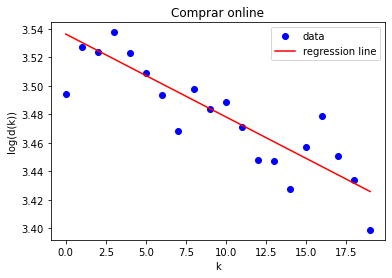

MLE (Rosenstein Algorithm= -0.005812263618208153


In [24]:
# Estimates the largest Lyapunov exponent 
# (a positive exponent is a strong indicator for chaos)
# Comprar online
plt.title('Comprar online')
le1 = nolds.lyap_r(df['Comprar_online'], debug_plot=True)
plt.show()
print('MLE (Rosenstein Algorithm=',le1)

The negative value of the largest LE shows that time-series can be described as a system not sensitive to initial conditions.

In [25]:
1/le, 1/le1

(50.11918771367932, -172.05000765403813)

## Sample Entropy

 The sample entropy of a time series is defined as the negative natural logarithm of the conditional probability that two sequences similar for emb_dim points remain similar at the next point, excluding self-matches.
### A lower value for the sample entropy therefore corresponds to a higher probability indicating more self-similarity.


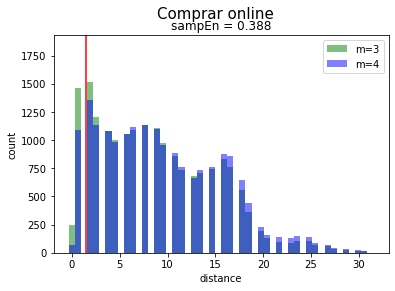

In [26]:
plt.suptitle('Comprar online', size=15)
nolds.sampen(df['Comprar_online'], debug_plot=True)
plt.show()

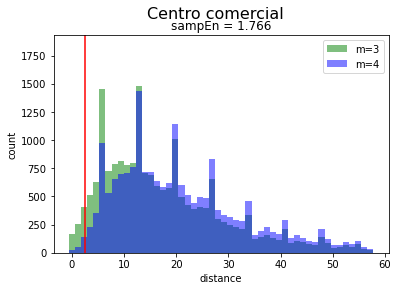

In [99]:
plt.suptitle('Centro comercial', size=16)
nolds.sampen(df['Centro_comercial'], debug_plot=True)
plt.show()

## Hurst exponent

 The Hurst exponent is a measure for the 'long-term memory' of a time series, meaning the long statistical dependencies in the data that do not originate from cycles.

It originates from H.E. Hursts observations of the problem of long-term storage in water reservoirs. If $x_i$ is the discharge of a river in year i and we observe this discharge for N years, we can calculate the storage capacity that would be required to keep the discharge steady at its mean value.

To do so, we first substract the mean over all $x_i$ from the individual $x_i$ to obtain the departures $x’_i$ from the mean for each year $i$. As the excess or deficit in discharge always carrys over from year $i$ to year $i+1$, we need to examine the cumulative sum of $x’_i$, denoted by $y_i$. This cumulative sum represents the filling of our hypothetical storage. If the sum is above 0, we are storing excess discharge from the river, if it is below zero we have compensated a deficit in discharge by releasing water from the storage. The range (maximum - minimum) $R$ of $y_i$ therefore represents the total capacity required for the storage.

 Hurst showed that this value follows a steady trend for varying N if it is normalized by the standard deviation sigma over the $x_i$. Namely he obtained the following formula:

$R/sigma$ = $(N_2)^K$

In this equation, $K$ is the Hurst exponent. Its value is 0.5 for white noise, but becomes greater for time series that exhibit some positive dependency on previous values. For negative dependencies it becomes less than 0.5.


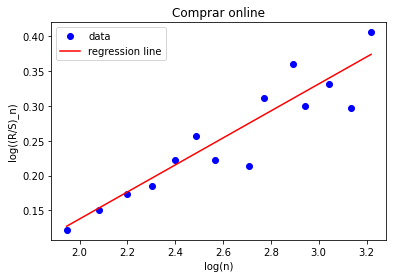

0.6937763786392757

In [28]:
plt.title ('Comprar online') 
nolds.hurst_rs(df['Comprar_online'], nvals=None, fit=u'RANSAC', debug_plot=True)

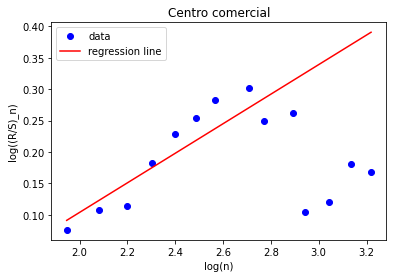

0.7353199085317212

In [29]:
plt.title ('Centro comercial') 
nolds.hurst_rs(df['Centro_comercial'], nvals=None, fit=u'RANSAC', debug_plot=True)

both exponents, H,  are higher than 0.5, so time series exhibit some positive dependency on previous values. If $H < 0.5$, the series has high noise and a high fractal dimension. For $H = 0.5$, we have a randomwalk equivalent, so we can model with a normal distribution. If  $ 0.5 < H < 1 $, time series are chaotic.

### Fractal dimension

The relationship $D_F=2−H$ is appealing in its simplicity, and indeed is frequently found in the literature; however is quick to acknowledge the inherent difficulty in assigning a fractal dimension to a self-affine structure, given that such a construction is predicated upon assigning an arbitrary rescaling relationship between incompatible coordinates. Mandelbrot, too, notes the apparent relation $D_F=2−H$ and clarifies that this relation holds in the fine-scale limit. This disparity serves to highlight a general distinction between the Hurst exponent and the fractal dimension as descriptors of a time-series trace.   

 Specifically:

Hurst exponent -  descriptor of global correlations

Fractal dimension -  describing a trace’s local fine-scale structure.

In [79]:
print('Fractal dimension for Centro Comercial = 2 - H =', 2-0.7353199085317212),

Fractal dimension for Centro Comercial = 2 - H = 1.2646800914682788


(None,)

In [81]:
print('Fractal dimension for Comprar Online = 2 - H =', 2-0.6937763786392757)

Fractal dimension for Comprar Online = 2 - H = 1.3062236213607243


### Maximal Lyapunov Exponent ( Wolf algorithm)

In [31]:
import math

In [32]:
def reconstitution(data,m,tau):
    N = len(data)
    M = N-(m-1)*tau 
    X = np.zeros((m,M))
    for j in range(M):
        for i in range(m):
            X[i][j] = data[(i-1)*tau+j]
    return X

Variables:

$m$: dimensions

$\tau$: time dealy

$data/os$: time series values

$N$: lenght of time series values

$P$: Time series average period. 

$\lambda_1$: Maximal Lyapunov Exponent

In [33]:
def lyapunov_wolf(data,N,m,tau,P):
    min_point=1  
    MAX_CISHU=5  
    max_d = 0                                       
    min_d = 1.0e+100                                
    avg_dd = 0
    Y=reconstitution(data,m,tau)                  
    M=N-(m-1)*tau                                   
    for i in range(M-1):
        for j in range(i+1,M):
            d = 0
            for k in range(m):
                d = d + (Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][j])
            d = math.sqrt(d)
            if max_d < d :
                max_d = d
            if min_d > d:
                min_d =d
            avg_dd = avg_dd + d
    avg_d = 2*avg_dd/(M*(M-1))                
    
    dlt_eps = (avg_d - min_d) * 0.02         
    min_eps = min_d + dlt_eps / 2             
    max_eps = min_d + 2 * dlt_eps          
        
  
    DK = 1.0e+100                            
    Loc_DK = 1                               
    for i in range(P+1,M-1): 
        d =0 
        for k in range(m):
            d = d + (Y[k][i] -Y[k][0]) *(Y[k][i] - Y[k][0])
        d = math.sqrt(d)
        if (d < DK) and (d > min_eps):
            DK = d
            Loc_DK = i
  
    sum_lmd = 0                             
    lmd = np.zeros(M-1)
    for i in range(1,M-1):                 
        DK1 = 0
        for k in range(m):
            DK1 = DK1 + (Y[k][i]-Y[k][Loc_DK+1])*(Y[k][i]-Y[k][Loc_DK+1])
        DK1 = math.sqrt(DK1)
        old_Loc_DK = Loc_DK               
        old_DK=DK

       
        if (DK1 != 0)and ( DK != 0):
            sum_lmd = sum_lmd + np.log(DK1/DK) /np.log(2);
        
        lmd[i-1] = sum_lmd/[i] 
       
        point_num = 0 
        cos_sita = 0  
        zjfwcs=0    
        while (point_num == 0):
         
            for j in range(M-1):
                if abs(j-i) <= (P-1):     
                    continue       
               
                dnew = 0
                for k in range(m):
                    dnew = dnew + (Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][j])
                dnew = math.sqrt(dnew)
                if (dnew < min_eps) or ( dnew > max_eps):   
                    continue           
                
                DOT = 0
                for k in  range(m):
                    DOT = DOT+(Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][old_Loc_DK+1])
                CTH = DOT/(dnew*DK1)
                #print(CTH)
                if CTH >1.0:
                    CTH = 1.0
                if math.acos(CTH) > (3.14151926/4):      
                    continue
                if CTH > cos_sita:  
                    cos_sita = CTH
                    Loc_DK = j
                    DK = dnew
                point_num = point_num +1
                
            if point_num <= min_point:
                max_eps = max_eps + dlt_eps
                zjfwcs =zjfwcs +1
                if zjfwcs > MAX_CISHU:   
                    DK = 1.0e+100
                    for ii in range(M-1):
                        if abs(i-ii) <= (P-1):     
                            continue   
                        d = 0
                        for k in range(m):
                            d = d + (Y[k][i]-Y[k][ii])*(Y[k][i]-Y[k][ii])
                        d = math.sqrt(d)
                        if (d < DK) and  (d > min_eps):
                            DK = d
                            Loc_DK = ii
                    break
                point_num = 0         
                cos_sita = 0

    plt.plot(lmd)
    plt.xlim(0,len(data))
    plt.show()
    lambda_1=sum(lmd)/len(lmd)
    return lambda_1

In [50]:
m = 1
tau = 0
P = 5  # Time series average period

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


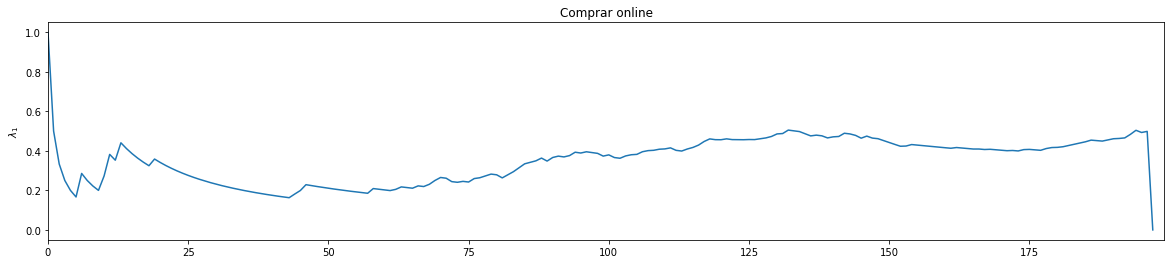

MLE (Wolf algorithm) = 0.3538870722098433


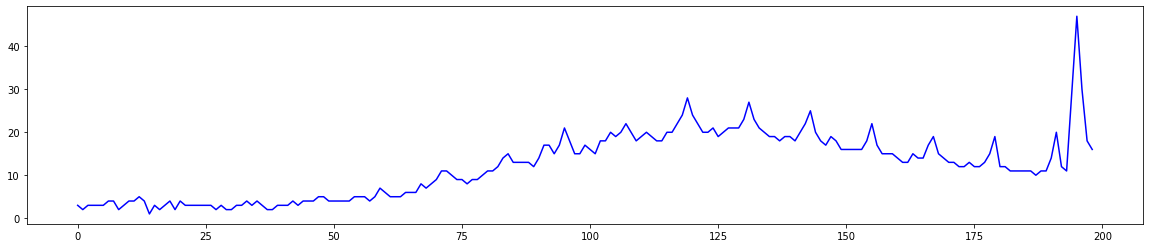

In [83]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 4))

plt.title('Comprar online')
plt.ylabel(r'$\lambda_1$')
data  = df['Comprar_online']
N = len(data)
lambda_1 = lyapunov_wolf(data,N,m,tau,P)
print('MLE (Wolf algorithm) =', lambda_1)

plt.figure(figsize=(20, 4))
df['Comprar_online'].plot(c='blue')
plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


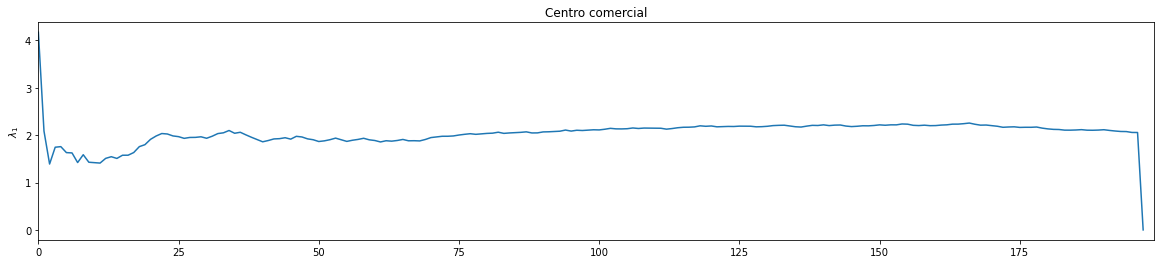

MLE (Wolf algorithm) =  2.0361060678339977


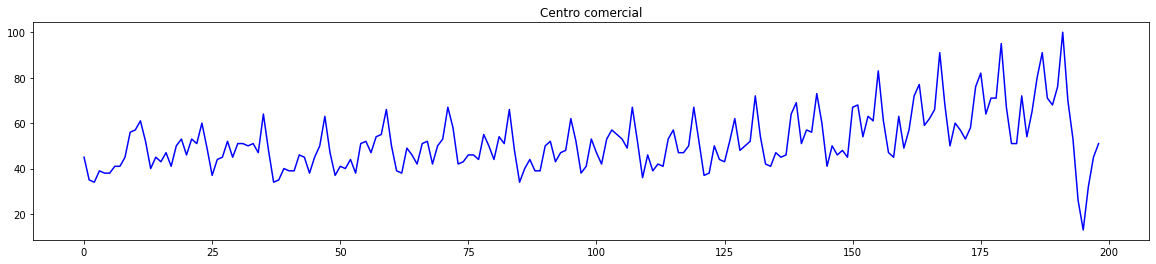

In [85]:
fig = plt.figure(figsize=(20, 4))
plt.title('Centro comercial')
plt.ylabel(r'$\lambda_1$')
data1  = df['Centro_comercial']
N1 = len(data)
lambda_1_1 = lyapunov_wolf(data1,N1,m,tau,P)
print('MLE (Wolf algorithm) = ', lambda_1_1)
plt.show()
plt.figure(figsize=(20, 4))
df['Centro_comercial'].plot(c='blue', title='Centro comercial')

plt.show()

## Fast Fourier Transform

### Comprar online

In [37]:
#Centro comercial
centro_fft = np.fft.fft(np.asarray(df['Comprar_online'].tolist()))
fft_df = pd.DataFrame({'fft':centro_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
#fft_df.sort_values(by=['abs'], ascending=False, inplace=True)
#fft_df.reset_index(inplace=True)
#fft_df.drop(columns=['index'], inplace=True)
fft_df.head(n=20)

,fft,absolute,angle
0,2416.000000-0.000000j,2416.000000,-5.881976e-18
1,-431.792134+758.296715j,872.615812,2.088430e+00
2,156.0147307+3.0322480j,156.044201,1.943320e-02
3,89.481151+120.936435j,150.441011,9.337891e-01
4,62.919222+112.804382j,129.165232,1.062005e+00
5,68.1805270+80.2603280j,105.310515,8.665971e-01
6,54.2846240+99.4132680j,113.268787,1.070991e+00
7,48.3199610+89.6109470j,101.808352,1.076268e+00
8,51.986692+122.467115j,133.044393,1.169353e+00
9,30.7104970+93.0345700j,97.972271,1.251961e+00


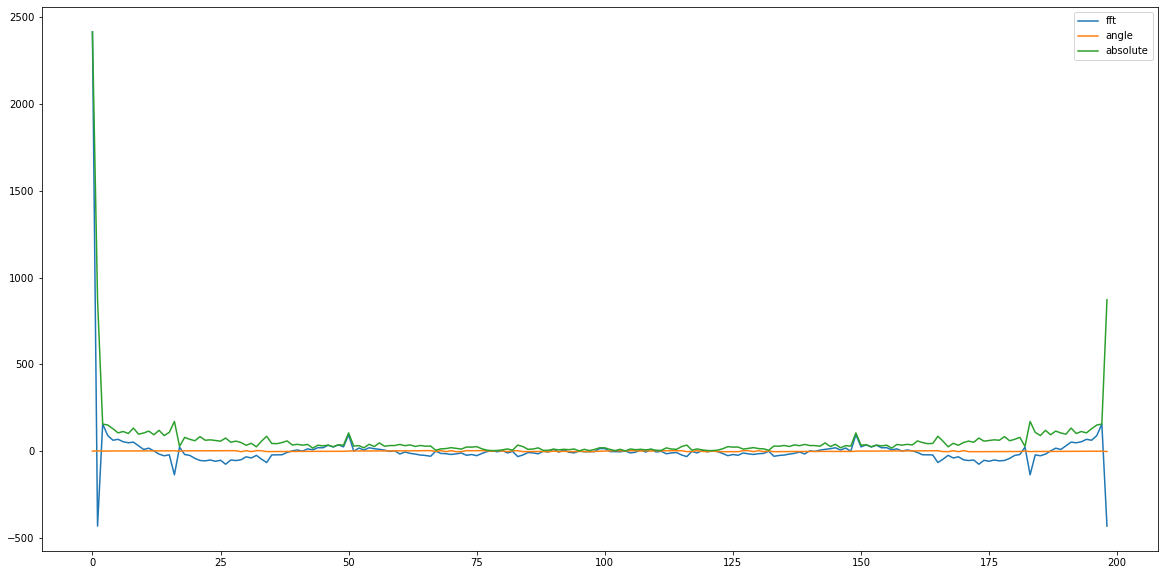

In [95]:
plt.figure(figsize=(20, 10))
plt.plot(fft_df['fft'], label='fft')
plt.plot(fft_df['angle'], label='angle')
plt.plot(fft_df['absolute'], label='absolute')
plt.legend()
plt.show()

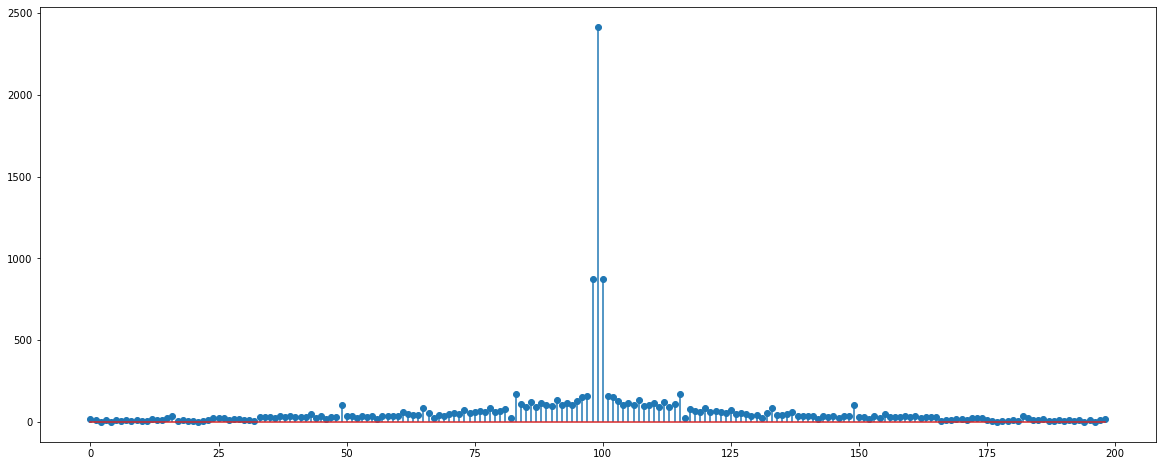

In [86]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(20, 8))
plt.stem(items, use_line_collection=True)
plt.show()

Once the spectral part of Fourier transform is removed, the magnitude part is quite close to the test series values.

## Low pass filtering

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


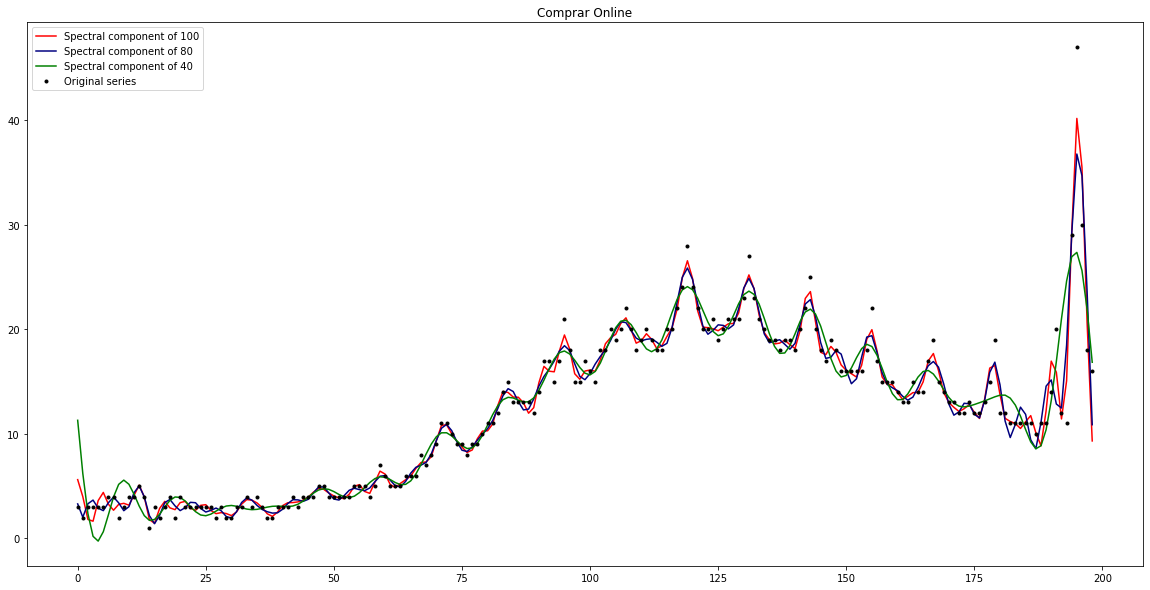

In [87]:
#Number of components is equal to c_half*2

c_half = 50  #100 components
fft_list = np.asarray(fft_df['fft'].tolist())
fft_list[c_half:-c_half] = 0

c_half1 = 40  #100 components
fft_list1 = np.asarray(fft_df['fft'].tolist())
fft_list1[c_half1:-c_half1] = 0

c_half2 = 20  #100 components
fft_list2 = np.asarray(fft_df['fft'].tolist())
fft_list2[c_half2:-c_half2] = 0

plt.figure(figsize=(20, 10))
plt.title('Comprar Online')
plt.plot(np.fft.ifft(fft_list), c='red', label='Spectral component of 100')
plt.plot(np.fft.ifft(fft_list1), c='navy', label='Spectral component of 80')
plt.plot(np.fft.ifft(fft_list2), c='green', label='Spectral component of 40')
plt.plot(np.fft.ifft(np.asarray(fft_df['fft'].tolist())), '.', c='black', label='Original series')
plt.legend()
plt.show()

## Pynamical

Python package for modeling, simulating, visualizing, and animating discrete nonlinear dynamical systems and chaos. Pynamical uses pandas, numpy, and numba for fast simulation, and matplotlib for visualizations and animations to explore system behavior.

Pynamical comes packaged with the `logistic ma`, the`Singer ma`, and the`cubic ma` predefined.

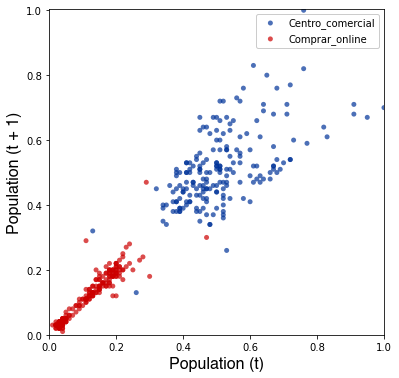

In [92]:
#Logistic Map
import pynamical
from pynamical import phase_diagram, phase_diagram_3d

data= df['Centro_comercial']
data1 = df['Comprar_online']
data = pd.DataFrame(data)
data1=pd.DataFrame(data1)
data2 = pd.concat([data, data1], axis=1)
phase_diagram(data2/100, size=100, color=['#003399','#cc0000'], ymax=1.005, legend=True)

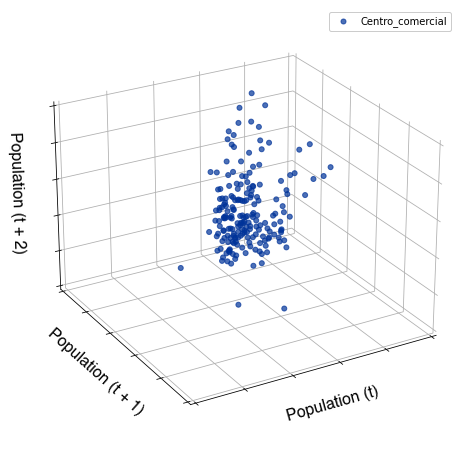

In [89]:
phase_diagram_3d(data/100, size=100, legend=True)

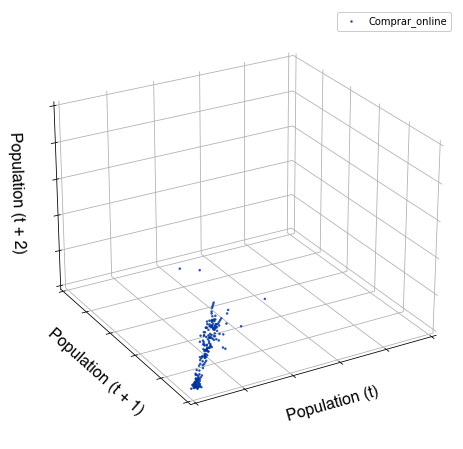

In [91]:
phase_diagram_3d(data1/100, size=10, legend=True)